## Cluster Mass Inference Summary
### Sean McLaughlin
---
Fall 2015 I started as a graduate student at Stanford. For my first rotation, I worked with Risa Wechsler and Phil Marshall on a portion of the Pangloss project. My goal was to infer the mass-richness relation for galaxy clusters via a large Bayesian heirarchical model. I started with this as my project for Physics 366, and kept working for the second half of the quarter. Development was fairly haphazard, so this notebook is to condense my findings for future readers (which may end up being me). 

## Model(s) and PGM(s)
---

There were two similar models used in this work. The first was a naive power law relation between mass and richness:

$ \lambda = a M^b + \varepsilon_{\sigma} $

Where $\varepsilon_{\sigma}$ is log normally distributed error with variance $\sigma^2$.  $a$, $b$, and $\sigma$ are free parameters of the model. 

At some point Risa suggested a slightly more complex model from an unpublished paper of hers with a more explicit redshift dependance. It has the form:

$\log{\lambda} = \log{\lambda_0} + A_{\lambda} \log{\frac{M}{M_{piv}}}+B_{\lambda}\log{\frac{1+z}{1.3}} + \epsilon_{\sigma} $

Where $A_{\lambda}$ is defined to have redshift dependence:

$ A_{\lambda} = a (1+z)^b $

Where $\log$ is the natural logarithm, $M_{piv}$ is a defined pivot mass and $\epsilon_{\sigma}$ is normally distributed error with variance $\sigma^2$. The free parameters are then $\log{\lambda_0}$, $a$, $b$, $B_{\lambda}$, and $\sigma$. Notice that in the $b$ = $B_{\lambda} $ = 0 case, this new model reduces to the simpler one. This model was employed partly to make use of available redshift information, and partly to make use of reasonable measured values from that unpublished paper mentioned above. There is unfortunately a bit of notational confusion between these two; I'll use the notation of the more complex model unless otherwise specified. 

The crucial point of this project was to use Bayesian Heirarchical Inference to marginalize over parameters. This is because a richness is directly observable, but mass is not. For cosmological measurements, we need to have a mass proxy and know the constraints on it. This is clearly shown in a graphical model. 

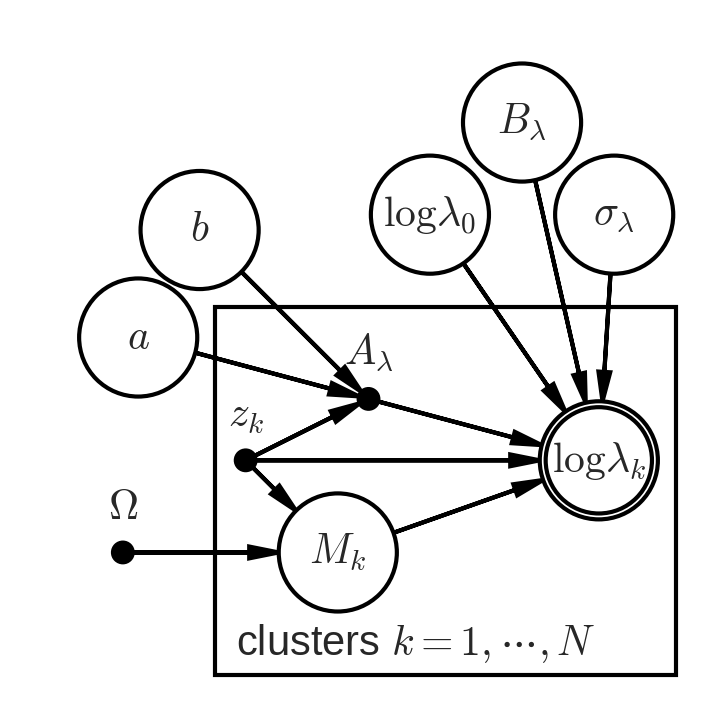

In [1]:
from IPython.display import Image
Image("newModelPGM.png")

This looks a bit more complex than it is. We are interested in inferring the distributions of some hyperparameters $\Theta$ (in this case $\Theta = \{a,b, \log{\lambda_0}, B_{\lambda}, \sigma_{\lambda} \} ) $. We wish to do this from some data $\{ \lambda \}$, some (assumed) perfectly known redshifts $\{ z \} $ and some (assumed) cosmology $\Omega$. This involves marginalizing over $N$ nuisance parameters ${M}$. This results in a challenging integral. 

This PGM decomposes to the probabilistic expression:

$P(\Theta | \{ \lambda \},  \{z\}, \Omega) = 
\int{ \prod_{k=1}^{N}{P( \lambda_k | M_k, z_k, \Theta)\; P(M_k | z_k, \Omega)\;dM_k \;P(\Theta) } } $

The majority of this work has focused on performing the above calculation efficently and accurately. For this work, $P( \lambda_k | M_k, z_k, \Theta)$ is the normal/lognormal liklihood of the richness given the model with parameters $\Theta$. I say normal/lognormal because it is lognormal if the calculation is being performed in linear space, but in practice it was often easier to work in log space with normal errors. Generally, uninformative priors were chosen for $P(\Theta)$. 

$P(M_k | z_k, \Omega) $ was chosen to be the mass function at a given redshift. To simplify calculations, an approximation was used. That approxmiation is given in [Evrard 2014](http://mnras.oxfordjournals.org/content/441/4/3562). It has the form:

$n_z(\mu) = A_z \exp{\sum_{i=1}^{3}{ \frac{ \beta_{i,z}\mu^i}{i!}}} $

Where $\mu = \frac{M}{M_{piv}} $ for some defined pivot mass. $A_z$ and $\beta_{i,z} $ are all functions of z. However, in the above paper values were only explicitly calculated for 2 redshifts. The approximation I chose to use was to interpolate between the given values as a function of z. Calling it a hack is generous, but it seemed to work fine for this application. 

## Data
---

Initially, the analysis for this project was going to be done with data from the Buzzard 1.1 simulation. There were a few problems with this. Firstly, it would be helpful to 1:1 pair the "measured" richnesses from redmapper to the "true" masses they have in the simulation. However, in practice this is more complicated, for a number of subtle reasons. I did have a catalog that Eli collected that approximated this effect, but there were additional issues. There are a few bugs in Buzzard that made this regression more difficult. 

It was proposed to take the masses from a simulation, and then forward model richnesses for each of these masses with some model. This worked quite well. Phil also suggested we take this another step further and sample masses from the mass function, and then forward model richnesses from those samples. This was convenient for giving complete control of all the variables entering the inference. Hopefully after things get up to scale these assumptions can be relaxed.

Code showing how to do this sampling is in this repository, but I'll provide a quick summary here since it took a little trial and error to get it working. Drawing a richness from the model given a mass was fairly trivial because it is simply a normal distribution; there are scipy packages for that. To draw from the mass function was a little trickier because it's not a normalized, stadard distribution. Phli had the good idea to use MCMC to draw the samples. After all, that's all MCMC is really for, drawing samples from distributions. 

## Inference with Known Masses
---
The first step to this was a sanity check. Assuming that instead of masses being marginalized over, they were measured. This removes the marginalization integral from the calculation. That was it can be established all the other pieces are working appropriately. 

The details of this inference are worked out in the *Inference New Model* notebook in this repository. Masses and redshifts were taken from a Buzzard catalog, and richnesses were drawn from the model given those values. MCMC was used to perform the inference, and the distributions were designed as described above. The true parameters used to sample the richnesses were able to be recovered without biases. 

## Importance Sampling
---
An attempt was made to perform the whole calculation with just MCMC, but it did not work. It is computationall intractable to perform the marginalization at this scale with MCMC. There was a degree of discussion about what approach would be best to take. Approximate Bayesian Computation (ABC) was considered, but ultimately it was decided to try Importance Sampling (IS) first. 

Phil worked out the basics of the math in a document [here](https://www.dropbox.com/s/6k6phbo6x0h4dvb/Importance%20Sampling%20in%20the%20Mass-Richness%20Relation%20Inference.pdf?dl=0). I also found [this pdf](http://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf) to be a great resource as well. I won't go through all the finer details of IS here, but I will cover the basics and the insights I gained while working with it. 

We are interested in calculating the liklihood:

$\mathcal{L} = \int{ \prod_{k=1}^{N}{P( \lambda_k | M_k, z_k, \Theta)\; P(M_k | z_k, \Omega)\;dM_k } }$

We can reorder the product and integral, such that:

$\mathcal{L} = \prod_{k=1}^{N}{\mathcal{L}_k} $

Where of course

$\mathcal{L}_k = \int{ P( \lambda_k | M_k, z_k, \Theta)\; P(M_k | z_k, \Omega)\;dM_k }$

Studying the above expression for $\mathcal{L}_k$, we can choose to look at it as the mean of the function $P( \lambda_k | M_k, z_k, \Theta)$ where $M_k$ is drawn from $P(M_k | z_k, \Omega)$. The estimator for the liklihood is

$\hat{\mathcal{L}}_k = \frac{1}{J}\sum_{j=1}^{J}{P( \lambda_k | M_{k,j}, z_k, \Theta)},\; M_{k,j} \sim P(M_k | z_k, \Omega) $

Now, the problem with this calculation is that the region of high liklihood that we are interested in is small compared to the size of the space. As the dimensonality $N$ increases, the relative volume of this sector of parameter space decreases, to the point where it is unlikely any significant number of sample points will be within that volume. So, the goal of IS is to bias our sampling to this "important" region, and then reweight our calculations to "cancel out" that bias. 

Multiplying the expression for $\mathcal{L}_k$ top and bottom by some sampling distribution $Q(M_k)$, we have:

$\mathcal{L}_k = \int{ P( \lambda_k | M_k, z_k, \Theta)\; \frac{P(M_k | z_k, \Omega)\;Q(M_k)}{Q(M_k)}\;dM_k }$

Which is of course unchanged. However, this can be seen as calculating the mean of a new expression over $Q$. So, our estimator becomes

$\hat{\mathcal{L}}_k = \frac{1}{J}\sum_{j=1}^{J}{P( \lambda_k | M_k, z_k, \Theta)\; \frac{P(M_k | z_k, \Omega)}{Q(M_k)}},\; M_{k,j} \sim Q(M_k) $

Hereafter I will use

$W_{j,k} = P( \lambda_k | M_k, z_k, \Theta)\; \frac{P(M_k | z_k, \Omega)}{Q(M_k)} $

So with a well chosen $Q$ we can make a better estimator! So what makes a better $Q$? I won't go into the nitty gritty of that because my above reference works through those calculations. Essentially, the best $Q(M_k) \propto P( \lambda_k | M_k, z_k, \Theta)\; P(M_k | z_k, \Omega)$. It also should have wide tails, as small values in denomintor will cause the variance to blow up. Dimensionality can also be a problem, as a poorly chosen $Q$ will cause small variance problems to grow exponentially with dimensionality. 

So, importance sampling is a little bit more art than science. I worked through implementing IS in the notebook *Importance Sampling* with mixed results. I believe that, here on the last day, it FINALLY works. There were a number of problems, most of them not my fault. I'll go through them, so no one has to repeat my mistakes.

* Not a general one, but this is the first time I drew mock data rather than using simulations. For simplicity, I chose to assume all masses were at the same redshift. The redshift parameters of the model ($b$ and $B_{\lambda}$) had not redshift information to go off of. Those parameters would vary wildly, and drag the rest of the points along with it. For this case, I just passed in their true values into the function. 

* The "wide tails" thing is no joke, and it can show up in unintuitive ways. I was using a wide Guassian as importance distribution, and I was getting weird results. I resorted to explictly evaluating the liklihood in a grid of parameter space to see how it behaved, and there were clear biases arising. It turned out to be a result of the weird cancelling of the sampling distribution and the other values. I switched to a Student's t with the same mean and variance and 1 d.o.f. and the problem was solved entirely. 

* The wide tailed distribution comes with it's own issues. Wide tails means extreme values are more likely; however, extreme values are unphysical, too. I haven't decided what the best course of action is for handling those samples. Clearly, the sampler shouldn't count on mass draws that are negative, or more than the mass of all the matter in the universe! Luckily, the mass function rules out extremely high masses already. However, lower mass objects are still allowed. I chose an arbitrary mass floor, and all sampled values below that had $P(M_k) = 0$. 

I implemented this sampler in the notebook mentioned above. The only change from the sampler with known masses was to write a new liklihood function that performed importance sampling. I chose a Student's T distribution for my importance distribution $Q$, centered on the most likely mass given a richness. 

$\log{M} = \log{M_{piv}} + \frac{1}{A_{\lambda}}\left( \log{\lambda}-\log{\lambda_0}-B_{\lambda}\log{\frac{1+z}{1.3}} \right) $

The scatter for this distribution was chosen arbitrarily, and can be adjusted easily. I chose, to start, the true values of the parameters as a really really good guess. In theory, as long as the estimates are close, the importance sampling will converge. It seems to be a backdoor way to enter prior information. 

For computational simplicity, I chose to draw one set of samples to be used at every evaluation. This likely isn't the most statistically kosher thing to do, but worked fine at least in practice. For the real deal I would move them inside the liklihood calculation, but the sample draw is fairly slow. 

## Future Work
---
Like all rotation projects, I didn't get as much done with this as I hoped to. There's a decent bit to continue with this. It's certainly not a complete list, but I'll try to rattle off a few things that I think are going to be important to work on with this.

* More robust tests of IS are essential. I've only tested it in a very special case and it was very finicky. Relaxing the strong assumptions I've made will put strain on this. 

* After crunching through some of this math, I'm actually wondering if simple Monte Carlo might be a better fit. It's similar to what we're doing, just without the additional sampling distribution. If we can sample from the mass function well enough, we may not need to do all this IS stuff at all to get $\hat{\mathcal{L}}_k$. 

* This needs to be worked into the larger Pangloss structure.

* One of the many elephants in the room is how to turn this on its head. In this case we've worked to find these hyperparameters while assuming a cosmology. Ultimately, the goal will be reverse and we will want to infer cosmology given some parameters. It's vary unclear how to do that at this stage. 